In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os,gc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import time
import warnings
warnings.simplefilter("ignore")
colors = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [3]:
df_train = pd.read_csv('../Data/train_combined.csv')
df_test = pd.read_csv('../Data/test_combined.csv')
print(df_train.shape)
print(df_test.shape)

(590540, 434)
(506691, 433)


In [4]:
def top_missing_cols(df,n=10,thresh=80):
    """
    returns missing columns in dataframe with missing values percent > thresh
    if n=None. It will gave whole dataframe with missing values percent > thresh
    """
    
    dff = (df.isnull().sum()/df.shape[0])*100
    dff = dff.reset_index()
    dff.columns = ['col','missing_percent']
    dff = dff.sort_values(by=['missing_percent'],ascending=False).reset_index(drop=True)
    print(f'There are {df.isnull().any().sum()} columns in this dataset with missing values.')
    print(f'There are {dff[dff["missing_percent"] > thresh].shape[0]} columns with missing percent values than {thresh}%')
    if n:
        return dff.head(n)
    else:
        return dff

In [5]:
df_missing = top_missing_cols(df_train,n=None,thresh=50)
# Taking all column with missing percen > 50
missing_cols = df_missing['col']

There are 414 columns in this dataset with missing values.
There are 214 columns with missing percent values than 50%


In [6]:
# we will take all columns and group them based on missing percentage
nan_dict = {}
for col in missing_cols:
    count = df_train[col].isnull().sum()
    try:
        nan_dict[count].append(col)
    except:
        nan_dict[count] = [col]
        
for k,v in nan_dict.items():
    print(f'#####' * 4)
    print(f'NAN count = {k} percent: {(int(k)/df_train.shape[0])*100} %')
    print(v)

####################
NAN count = 585793 percent: 99.19615944728554 %
['id_24']
####################
NAN count = 585408 percent: 99.13096487960172 %
['id_25']
####################
NAN count = 585385 percent: 99.12707013919464 %
['id_07', 'id_08']
####################
NAN count = 585381 percent: 99.12639279303687 %
['id_21']
####################
NAN count = 585377 percent: 99.12571544687913 %
['id_26']
####################
NAN count = 585371 percent: 99.1246994276425 %
['id_27', 'id_23', 'id_22']
####################
NAN count = 552913 percent: 93.62837403054831 %
['dist2']
####################
NAN count = 551623 percent: 93.40992989467267 %
['D7']
####################
NAN count = 545427 percent: 92.36072069631184 %
['id_18']
####################
NAN count = 528588 percent: 89.50926270870728 %
['D13']
####################
NAN count = 528353 percent: 89.46946862193924 %
['D14']
####################
NAN count = 525823 percent: 89.04104717715988 %
['D12']
####################
NAN count = 52

In [7]:
def coorelation_analysis(cols,title='Coorelation Analysis',size=(12,12)):
    cols = sorted(cols)
    fig,axes = plt.subplots(1,1,figsize=size)
    df_corr = df_train[cols].corr()
    sns.heatmap(df_corr,annot=True,cmap='RdBu_r')
    axes.title.set_text(title)
    plt.show()

In [8]:
def reduce_groups(grps):
    '''
    determining column that have more unique values among a group of atttributes
    '''
    use = []
    for col in grps:
        max_unique = 0
        max_index = 0
        for i,c in enumerate(col):
            n = df_train[c].nunique()
            if n > max_unique:
                max_unique = n
                max_index = i
        use.append(col[max_index])
    return use

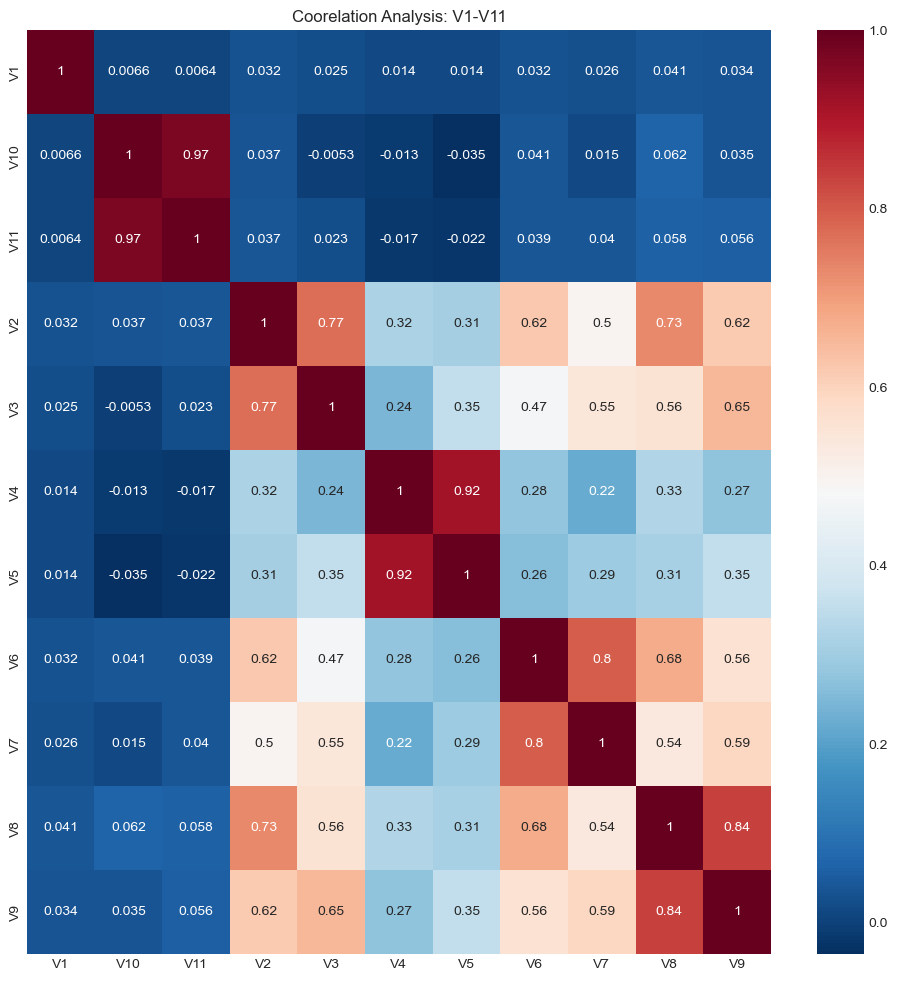

In [9]:
cols = ['V3', 'V9', 'V5', 'V11', 'V10', 'V8', 'V7', 'V6', 'V4', 'V2', 'V1']
coorelation_analysis(cols,title='Coorelation Analysis: V1-V11')

In [10]:
pairs = [['V1'],['V2','V3'],['V4','V5'],['V6','V7'],['V8','V9'],['V10','V11']]
reduce_groups(pairs)

['V1', 'V3', 'V4', 'V6', 'V8', 'V11']

## group2[V12 - V34]

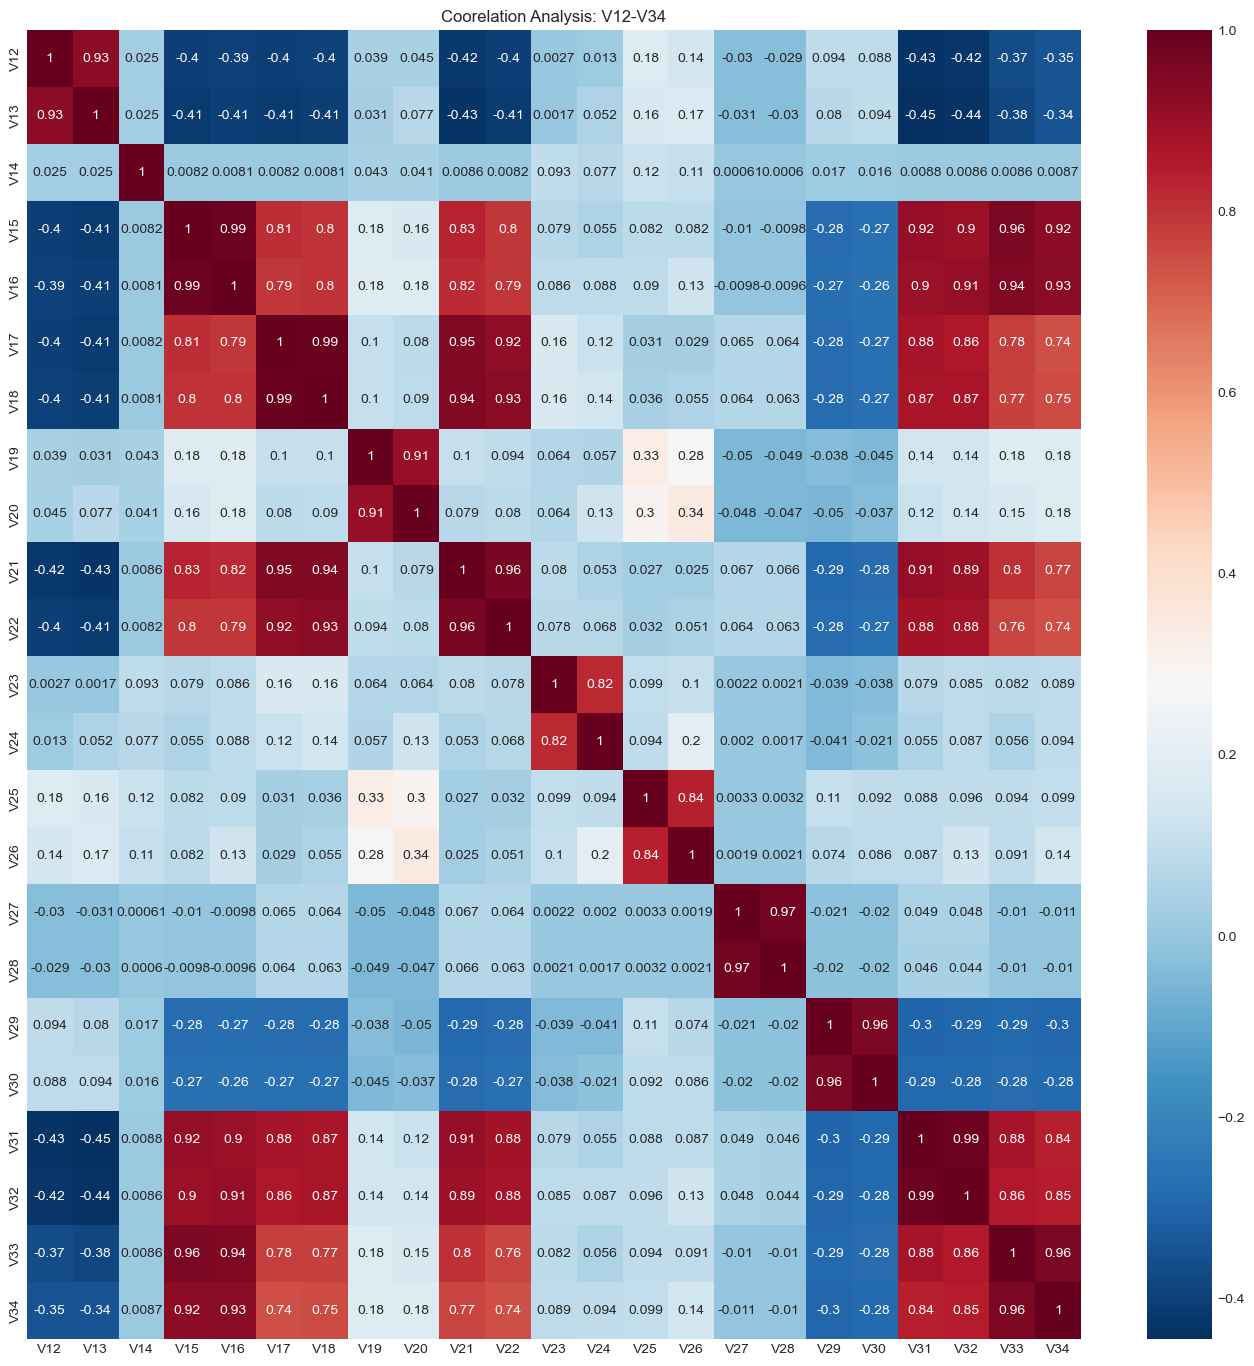

In [11]:
cols = ['V21', 'V22', 'V23', 'V34', 'V33', 'V32','V31', 'V30', 'V29', 'V28', 
         'V27', 'V25', 'V24', 'V26', 'V16', 'V15', 
        'V20', 'V14', 'V19', 'V18', 'V17', 'V12', 'V13']

coorelation_analysis(cols,title='Coorelation Analysis: V12-V34',size=(17,17))


In [12]:
pairs = [['V12','V13'],['V14'],['V15','V16','V17','V18','V21','V22','V31','V32','V33','V34'],['V19','V20'],
         ['V23','V24'],['V25','V26'],['V27','V28'],['V29','V30']]

red_cols = reduce_groups(pairs)
red_cols


['V13', 'V14', 'V17', 'V20', 'V23', 'V26', 'V27', 'V30']

## group3 [V35 - V52]

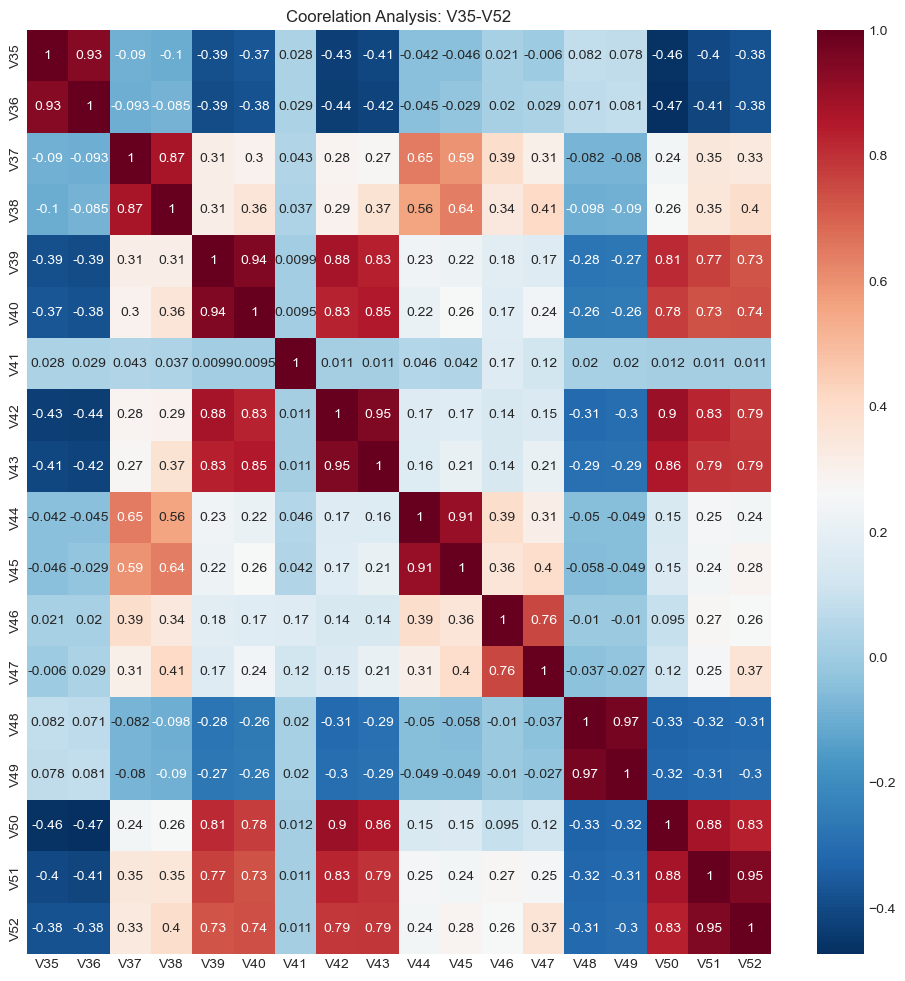

In [13]:
cols = ['V35', 'V40', 'V41', 'V39', 'V38', 'V51', 'V37', 'V52', 'V36', 'V50', 'V48', 'V42',
 'V43', 'V44', 'V46', 'V47', 'V45', 'V49']


coorelation_analysis(cols,title='Coorelation Analysis: V35-V52',size=(12,12))


In [14]:
pairs = [['V35','V36'],['V37','V38'],['V39','V40','V42','V43','V50','V51','V52'],['V41'],
         ['V44','V45'],['V46','V47'],['V48','V49']]

red_cols = reduce_groups(pairs)
red_cols


['V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48']

## group4 [V52-V74]

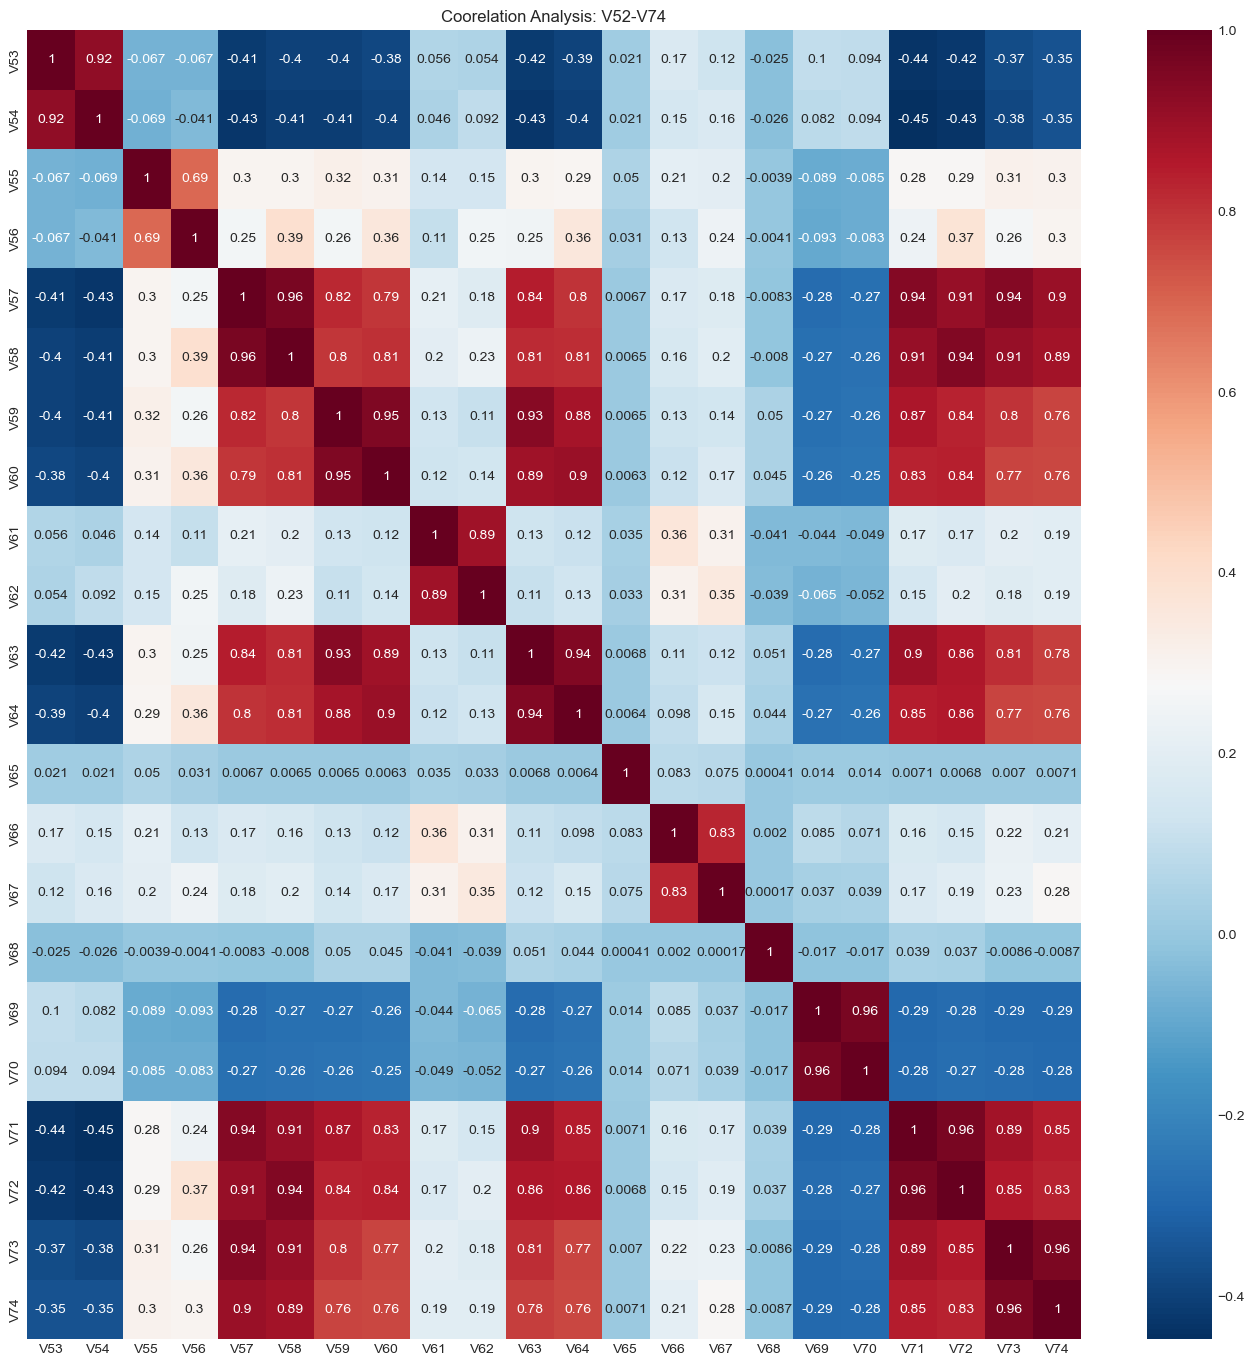

In [15]:
cols = ['V72', 'V74', 'V73', 'V71', 'V65', 'V68', 'V58', 'V70', 'V53', 
 'V54', 'V55', 'V56', 'V57', 'V59', 'V67', 'V60', 'V61',
 'V62', 'V63', 'V64', 'V66', 'V69']

coorelation_analysis(cols,title='Coorelation Analysis: V52-V74',size=(17,17))

In [16]:
pairs = [['V53','V54'],['V55'],['V56'],['V57', 'V58', 'V59', 'V60', 'V63', 'V64', 'V71', 'V72', 'V73', 'V74'],['V61','V62'],
 ['V65'],['V66','V67'],['V68'],['V69','V70']]



red_cols = reduce_groups(pairs)
red_cols

['V54', 'V55', 'V56', 'V59', 'V62', 'V65', 'V67', 'V68', 'V70']

## group5 [V75 - V94]

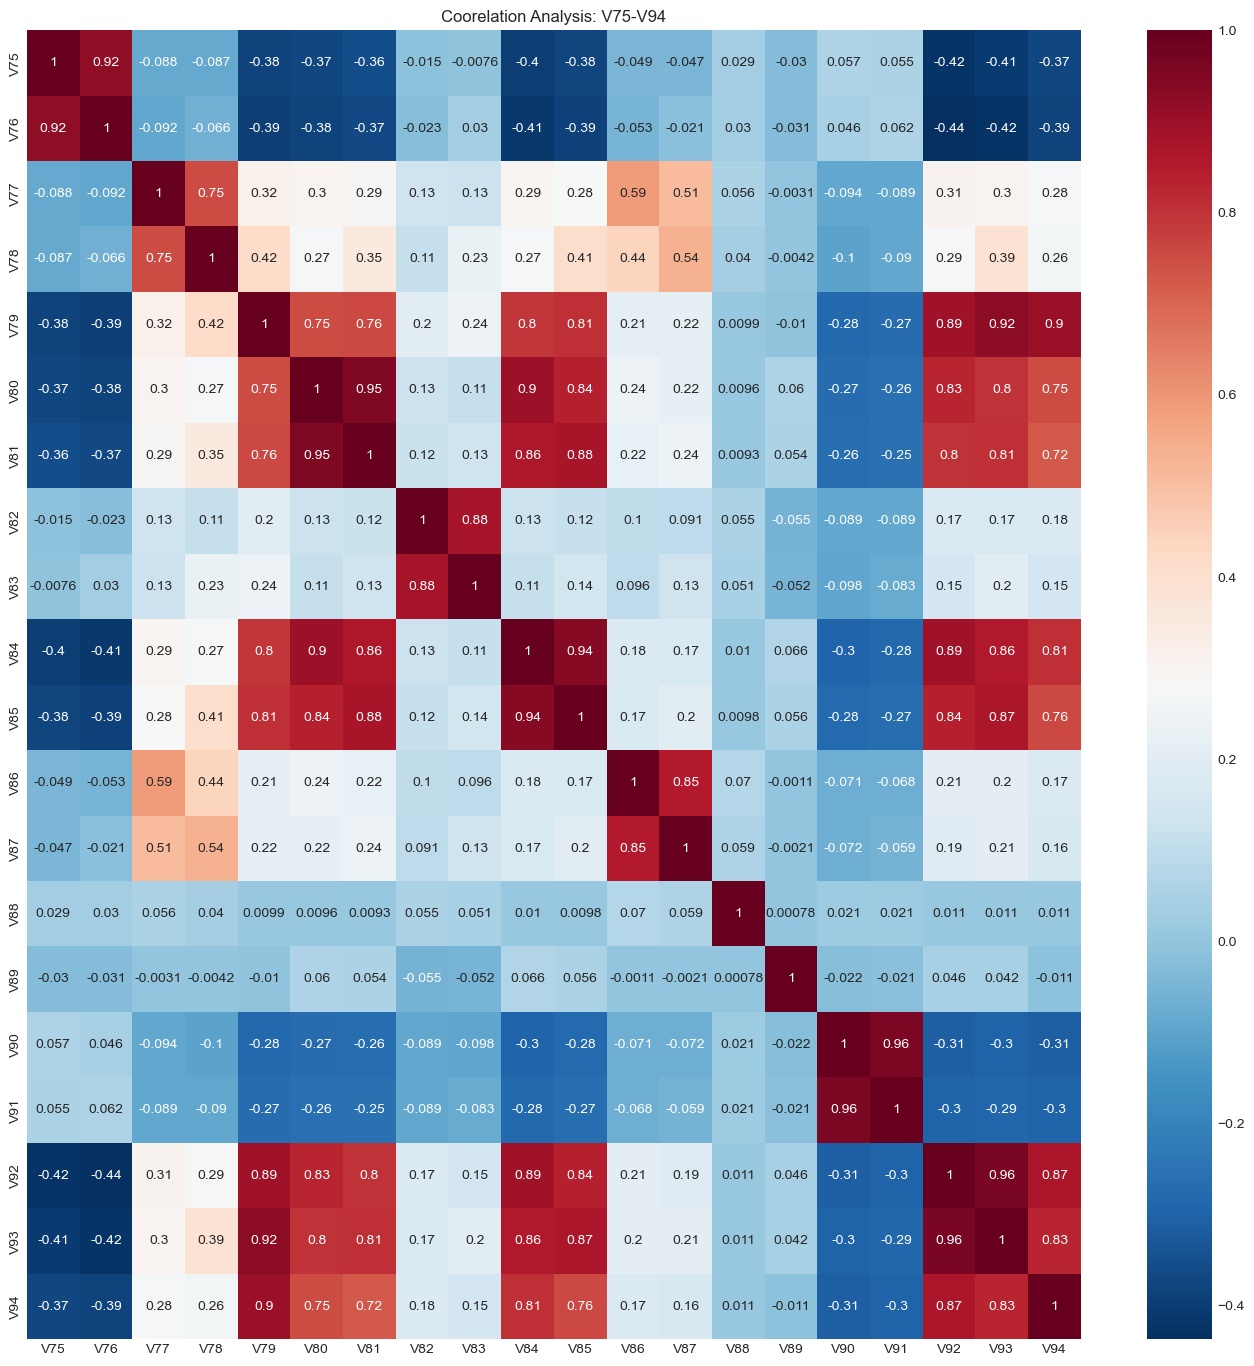

In [17]:
cols = ['V80', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V86', 'V79',
 'V85', 'V75', 'V84', 'V77', 'V83', 'V78', 'V82', 'V81', 'V76']

coorelation_analysis(cols,title='Coorelation Analysis: V75-V94',size=(17,17))


In [18]:
pairs = [['V75','V76'],['V77','V78'],['V79','V80','V81','V84','V85','V92','V93','V94'],['V82','V83'],['V86','V87'],
         ['V88'],['V89'],['V90','V91']]


red_cols = reduce_groups(pairs)
red_cols

['V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89', 'V91']

## group6 [V95 - V137]

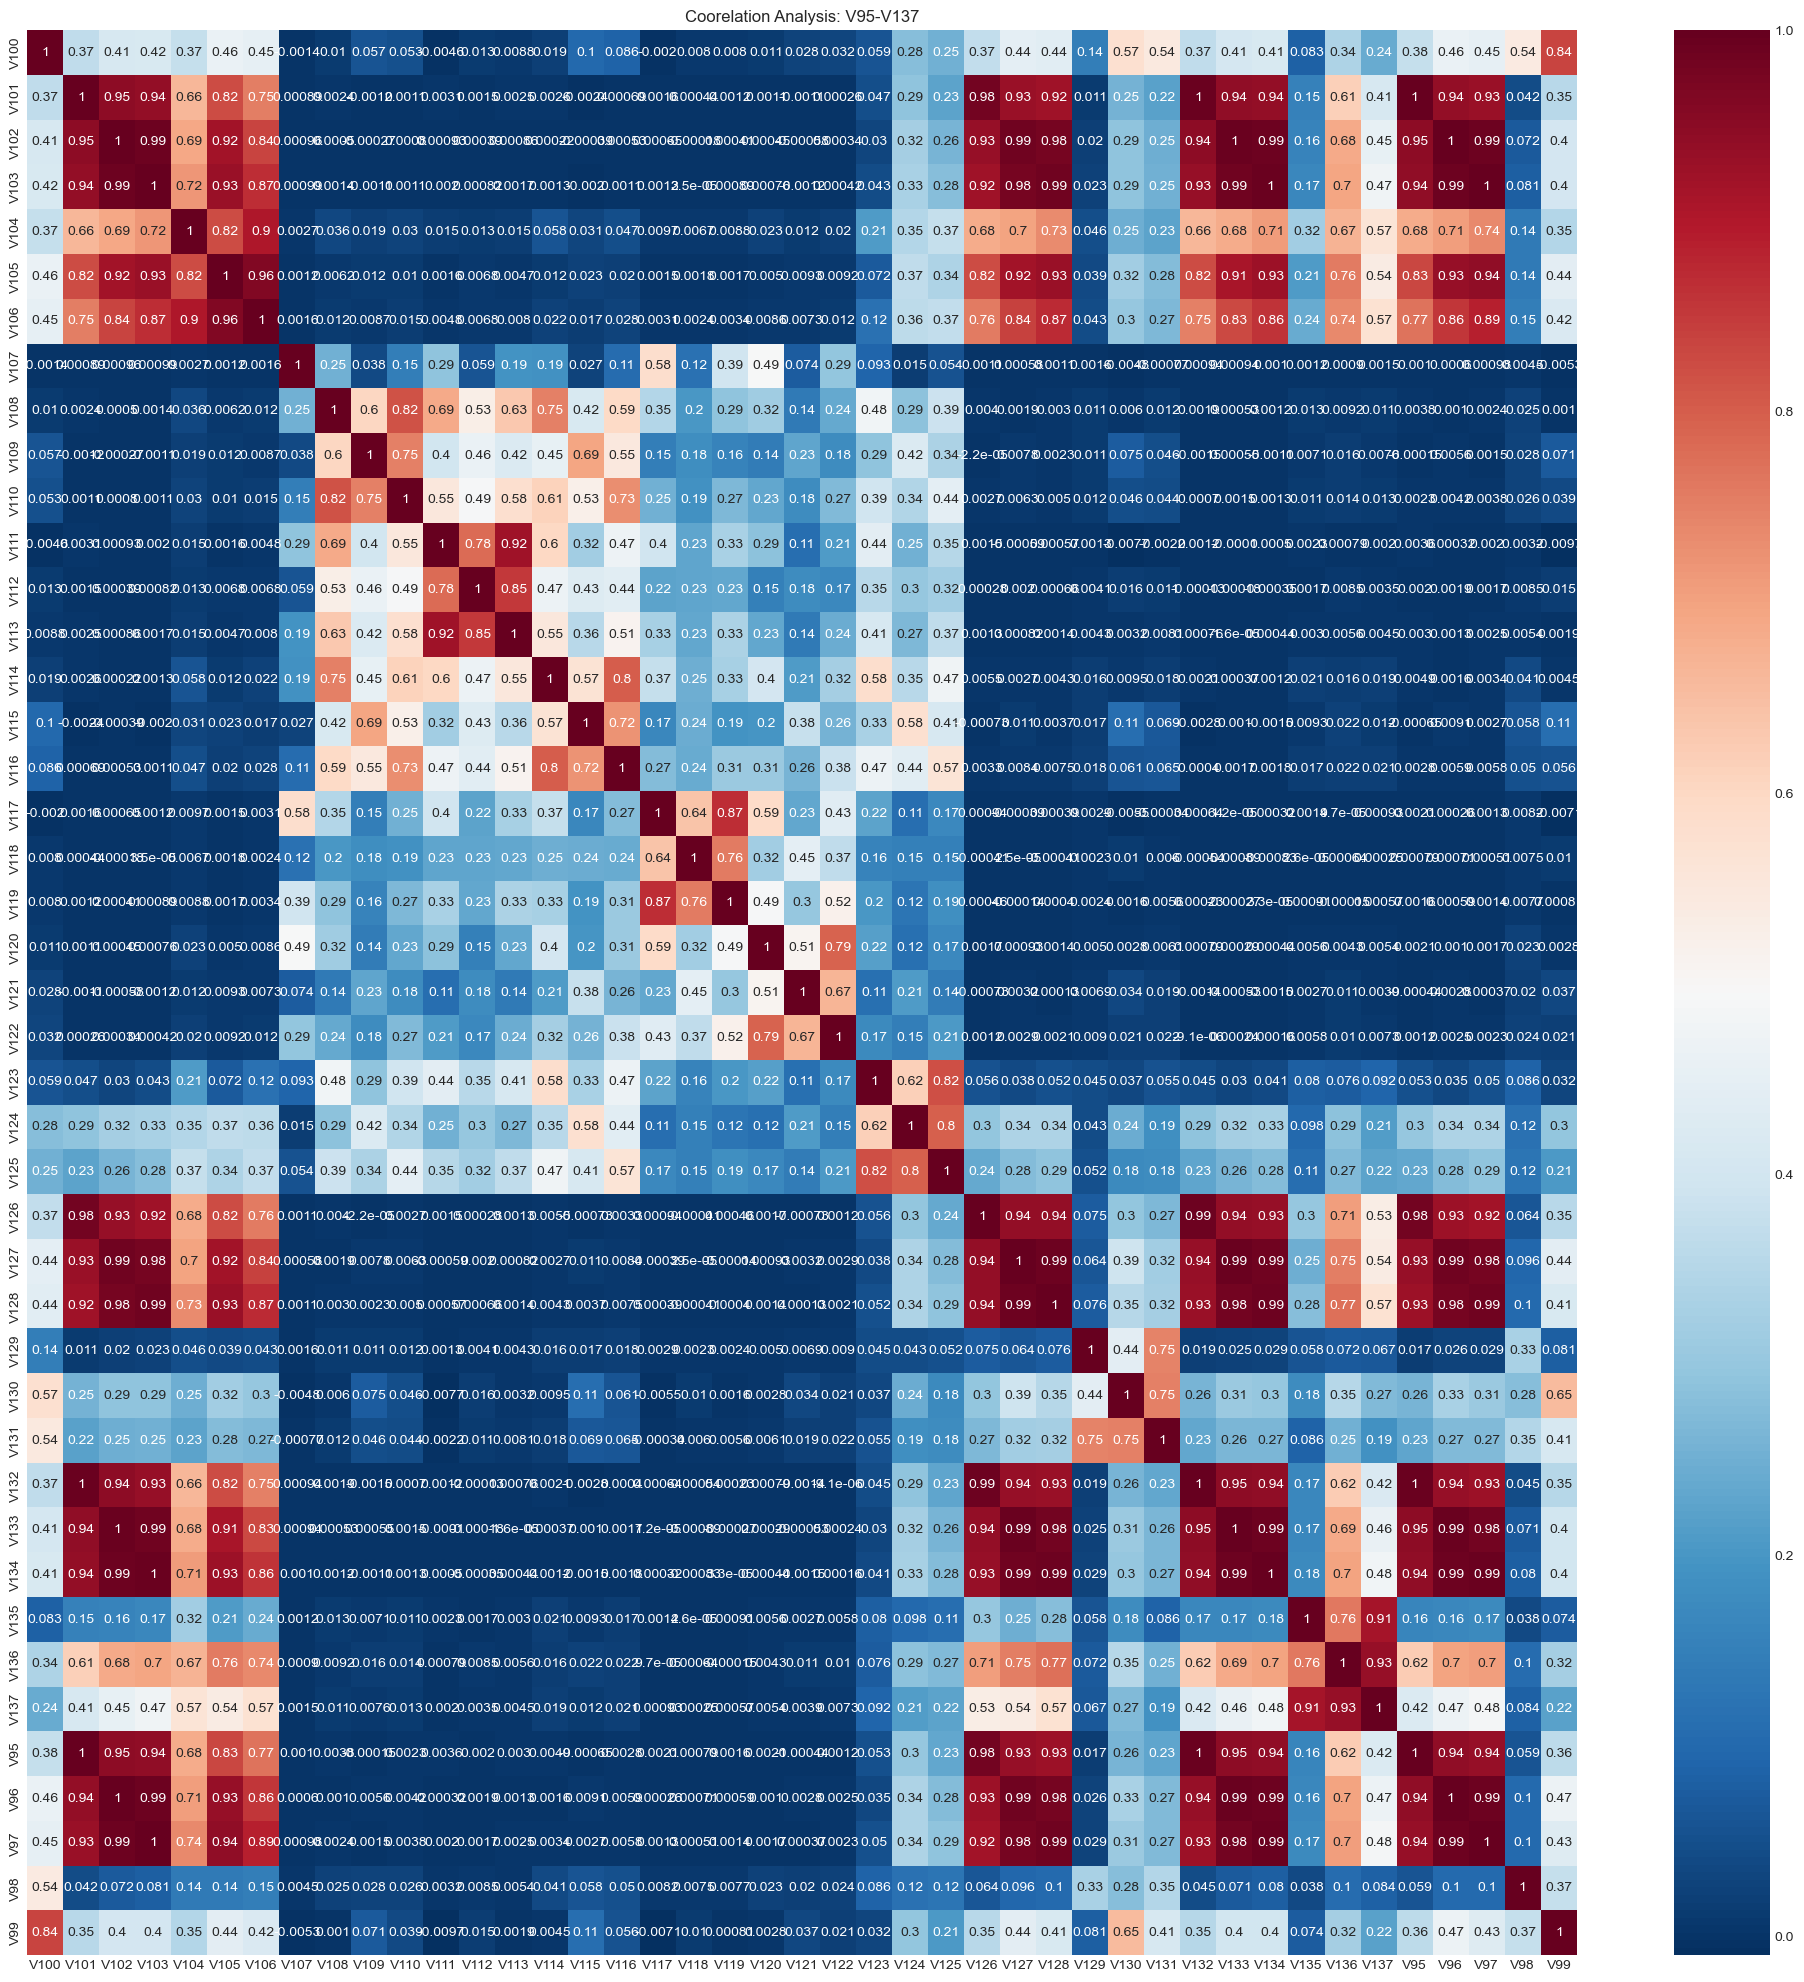

In [19]:
cols = ['V104', 'V109', 'V110', 'V111', 'V112', 'V106', 'V105', 'V102', 'V103', 'V96', 'V101', 'V100',
        'V99', 'V98', 'V97', 'V95', 'V135', 'V134', 'V107', 'V133', 'V132', 'V131', 'V130', 'V129', 
        'V128', 'V127', 'V126', 'V125', 'V124', 'V123', 'V122', 'V121', 
        'V120', 'V119', 'V118', 'V117', 'V116', 'V115', 'V114', 'V113', 'V136', 'V137', 'V108']

coorelation_analysis(cols,title='Coorelation Analysis: V95-V137',size=(25,25))

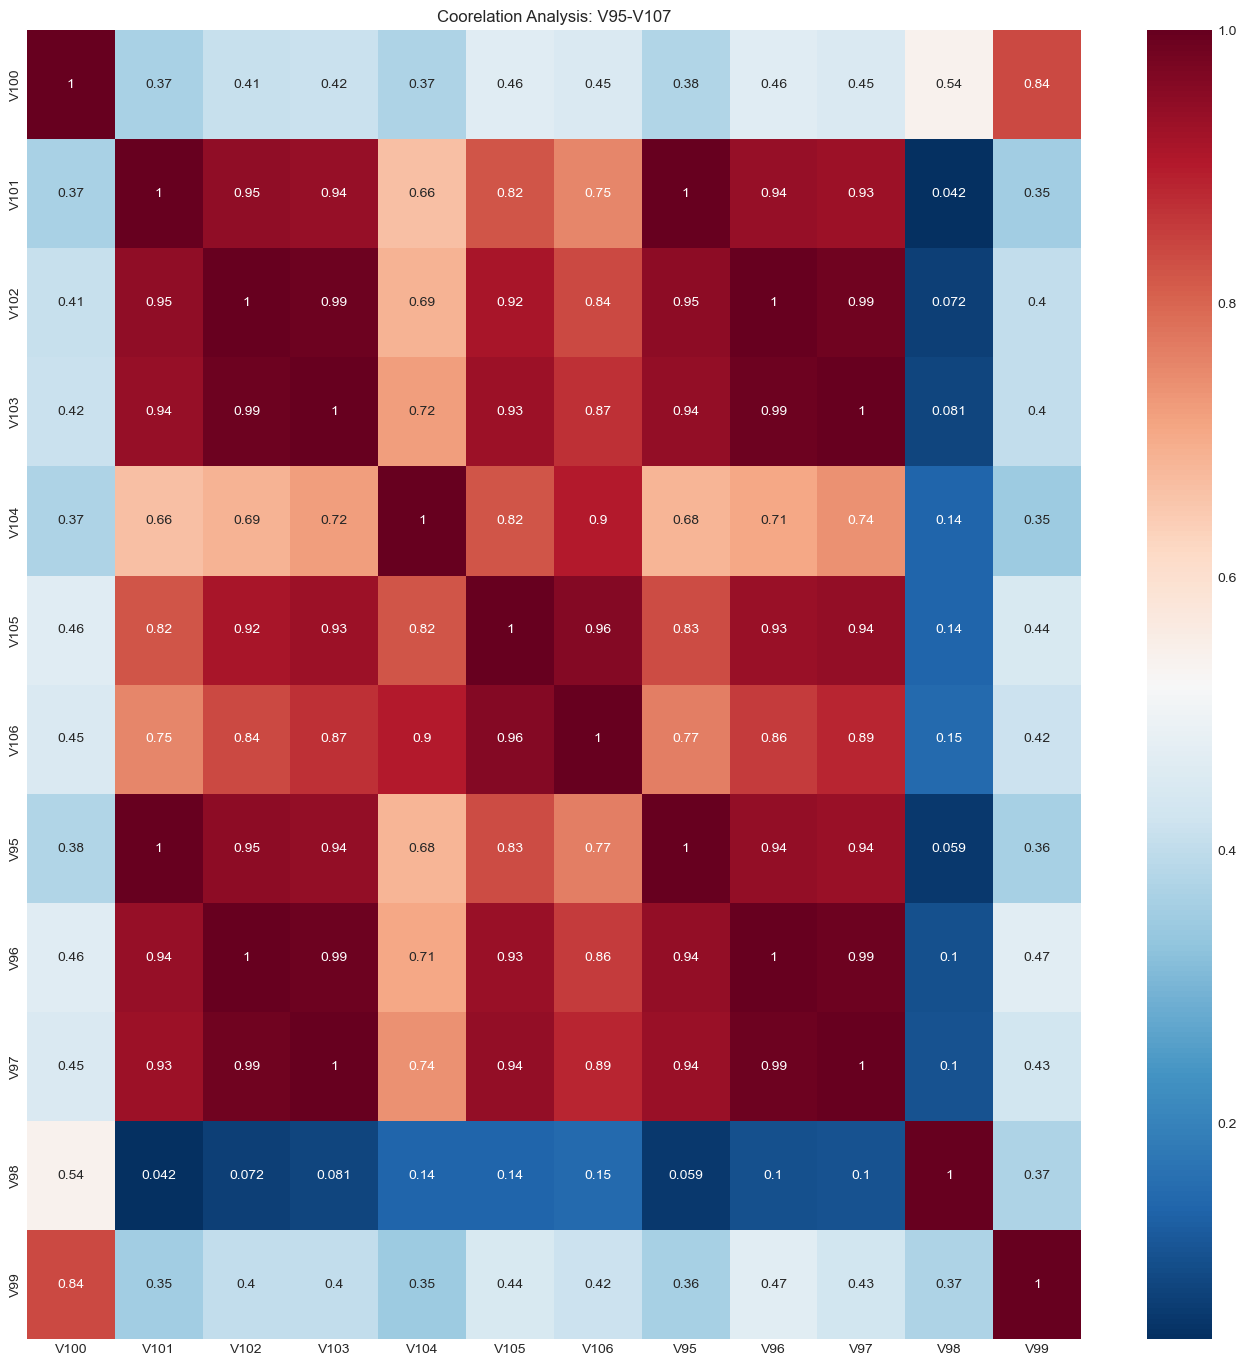

In [20]:
cols = ['V'+str(x) for x in range(95,107)]

coorelation_analysis(cols,title='Coorelation Analysis: V95-V107',size=(17,17))

In [21]:
pairs = [['V99','V100'],['V98'],['V104'],['V95','V96','V97','V101','V102','V103','V105','V106']]

red_cols = reduce_groups(pairs)
red_cols

['V99', 'V98', 'V104', 'V96']

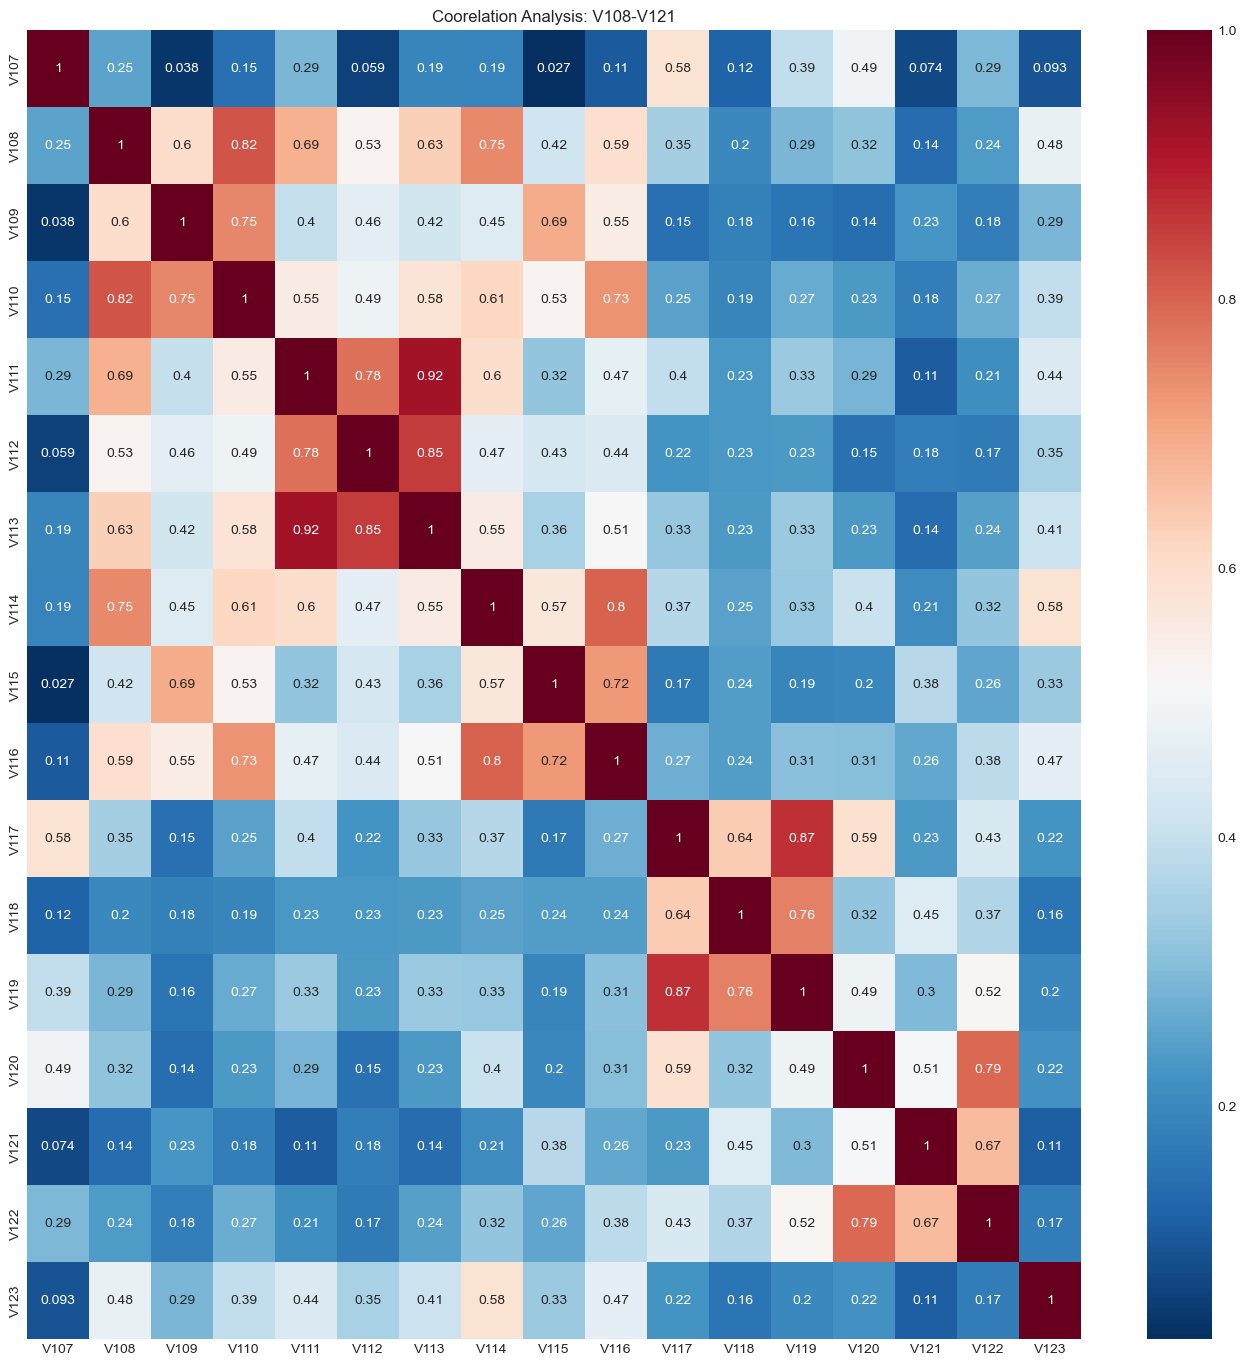

In [22]:
cols = ['V'+str(x) for x in range(107,124)]

coorelation_analysis(cols,title='Coorelation Analysis: V108-V121',size=(17,17))

In [23]:

pairs = [['V107'],['V108','V109','V110','V114'],['V111','V112','V113'],['V115','V116'],['V117','V118','V119'],['V120','V122'],['V121'],['V123']]

red_cols = reduce_groups(pairs)
red_cols

['V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121', 'V123']

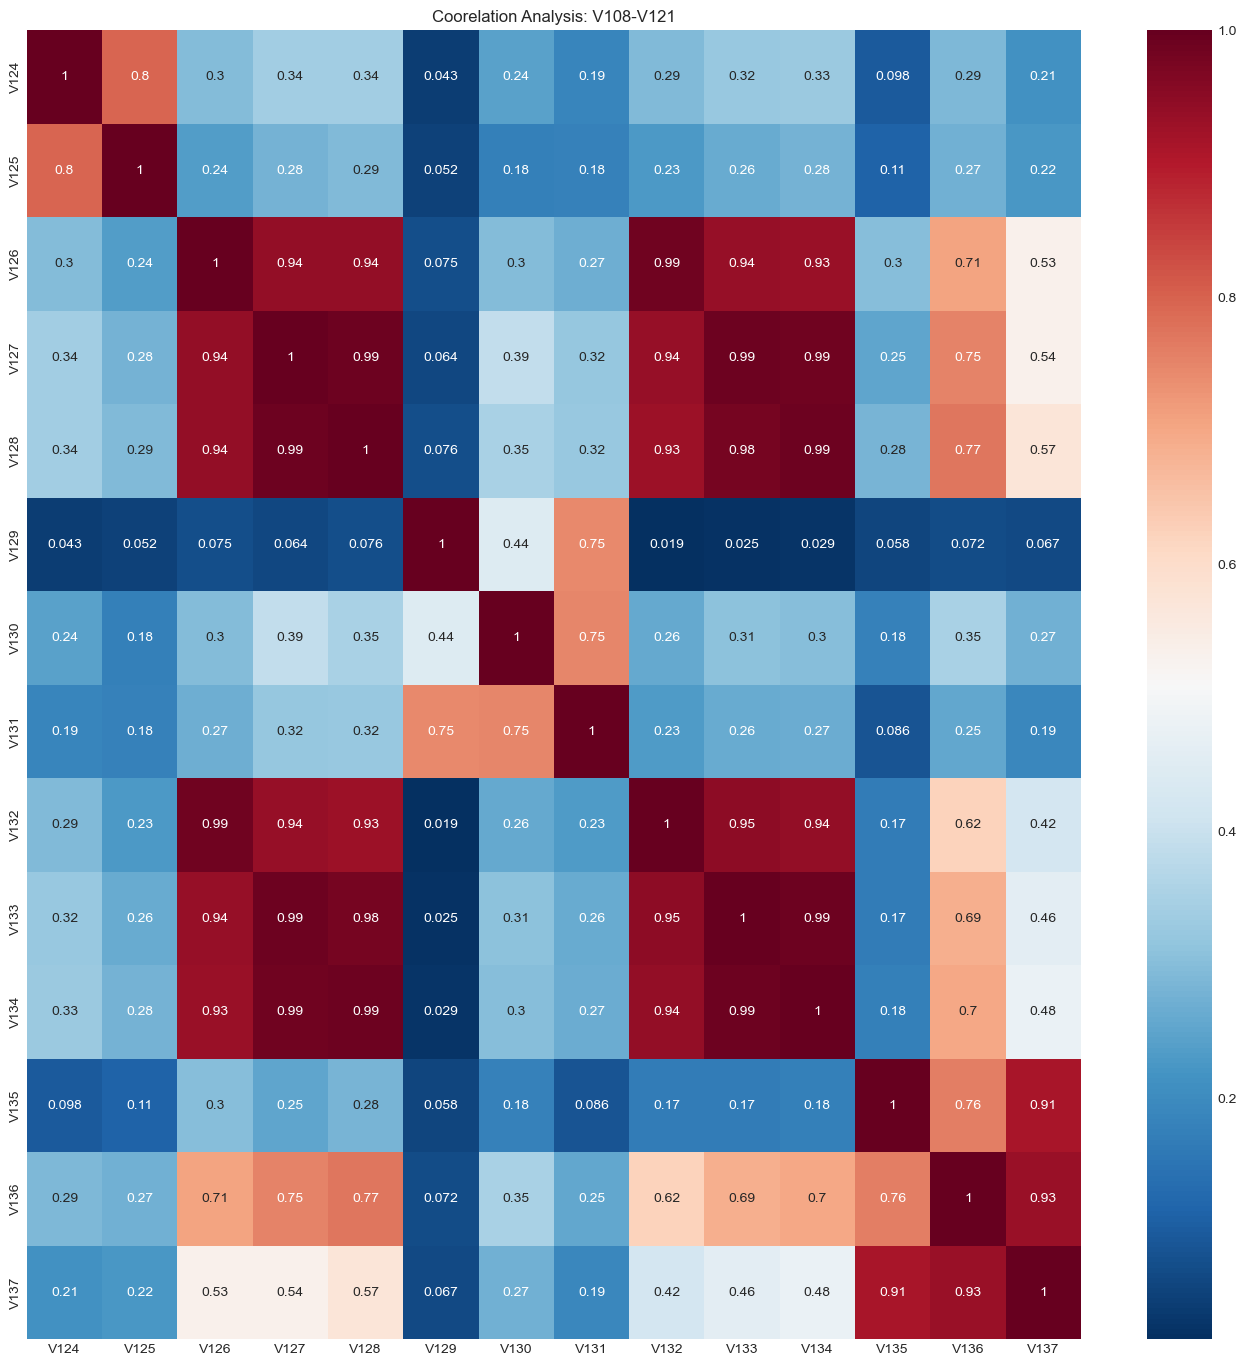

In [24]:
cols = ['V'+str(x) for x in range(124,138)]
coorelation_analysis(cols,title='Coorelation Analysis: V108-V121',size=(17,17))

In [25]:
pairs = [['V124','V125'],['V126','V127','V128','V132','V133','V134'],['V129'],['V130','V131'],['V135','V136','V137']]

red_cols = reduce_groups(pairs)
red_cols

['V124', 'V127', 'V129', 'V130', 'V136']